In [5]:
# Imports

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

# Load data
mat_file = loadmat('../sample_1.mat')


# Plotting Sample 1
## Interactive plot of the complete first sample
Interactive plot. You can zoom in and scroll along both axes. 

In [6]:
%matplotlib notebook

data = mat_file['data'][0]
plt.plot(data)

plt.show()

<IPython.core.display.Javascript object>

## Subplots of the first 10000 data points in sample 1
The first 10000 data points and the ground truth in a series of subplots. The axes are scaled so that we can observe what the spikes look like. The red lines parallel to the x axis mark the spike times of spikes in the data set. This is the ground truth. 

We can already observe that there seems to be an offset between the local maximum of a spike and the spike time. The most intuitive explanation for this is that the data set contains the times when a spike was induced through some trigger. As the system is slow the potential of the neurons rises slower and is detectable in form of a local maximum a few timesteps after the spike was induced. 

We will need to take this into account when detecting the spikes. 

<IPython.core.display.Javascript object>

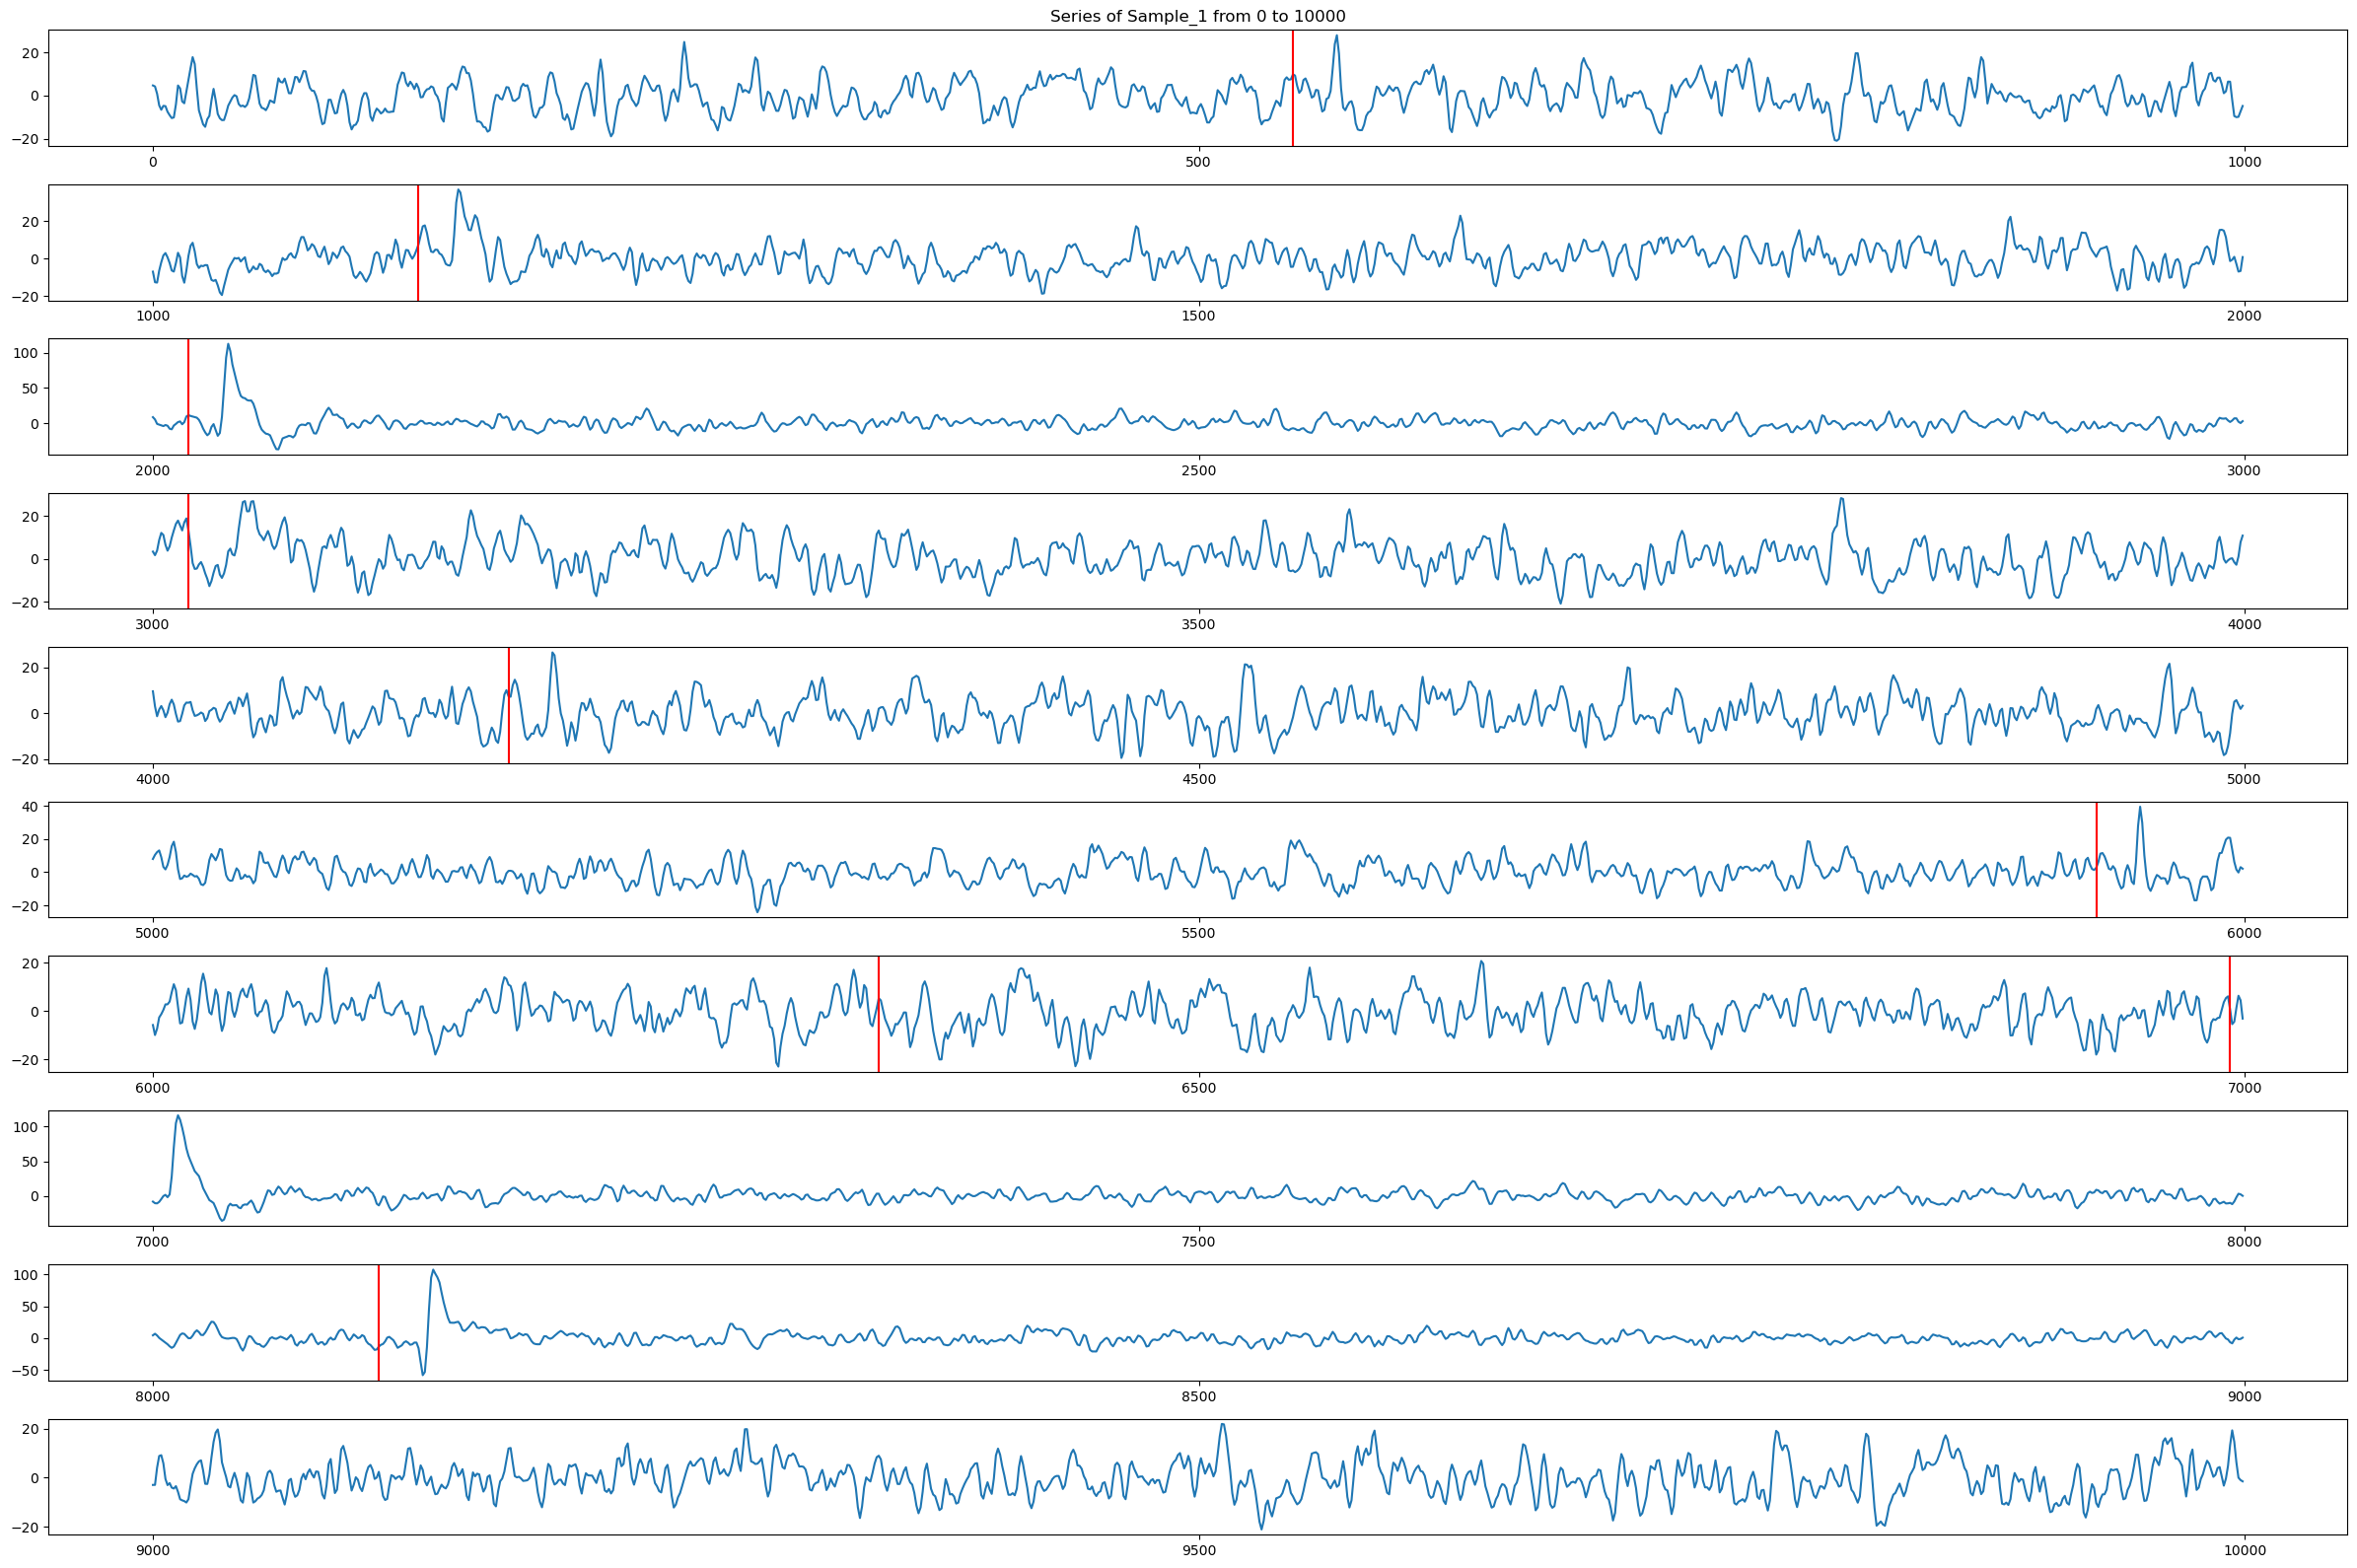

In [7]:
%matplotlib inline
data = mat_file['data'][0][:10000]
spike_times = mat_file['spike_times'][0][0][0]

# TODO: Add labels

SUBPLOT_SIZE = 1000
N_SUBPLOTS = data.shape[0]//SUBPLOT_SIZE

fig, ax = plt.subplots(nrows=N_SUBPLOTS, ncols=1, figsize=(24,16))


for i in range(0, N_SUBPLOTS):
    start = i*SUBPLOT_SIZE
    end = (i+1)*SUBPLOT_SIZE

    ax[i].plot(data[start:end])
    ax[i].set_xticks([0, SUBPLOT_SIZE // 2, SUBPLOT_SIZE])
    ax[i].set_xticklabels([start, (start + end) // 2, end])
    
    for j, truth in enumerate(spike_times):
        if start < truth <= end:
            ax[i].axvline(truth-start, color='red', label="ground truth")
    

ax[0].set_title("Series of Sample_1 from 0 to 10000")
plt.tight_layout()
# plt.savefig('figures/data_sample_1.pdf')
plt.show() 
    

## Spikes by Classes
The spikes are grouped into different classes according to their properties. Below are plots for each class to get a better understanding of what those properties are. 

In [8]:
def plot_clusters_by_class(class_label):
    data = mat_file['data'][0]
    classes = mat_file['spike_class'][0][0][0]
    spike_times = mat_file['spike_times'][0][0][0]
    
    spikes = spike_times[np.where(classes==class_label)]
    
    fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(24,16))
    
    for i in range(18):

        ax[i//3][i%3].plot(data[spikes[i]-50:spikes[i]+50])
        
    ax[0][1].set_title(f'Spikes of Class {class_label}')
    plt.tight_layout()
    # plt.savefig(f'figures/spike_class_{class_label}_plot.pdf')
    plt.show()

# for debugging
# plot_clusters_by_class(2)

print("Classes in the sample are:")
classes = mat_file['spike_class'][0][0][0]
print(np.unique(classes))

Classes in the sample are:
[0 1 2]


### Class 0

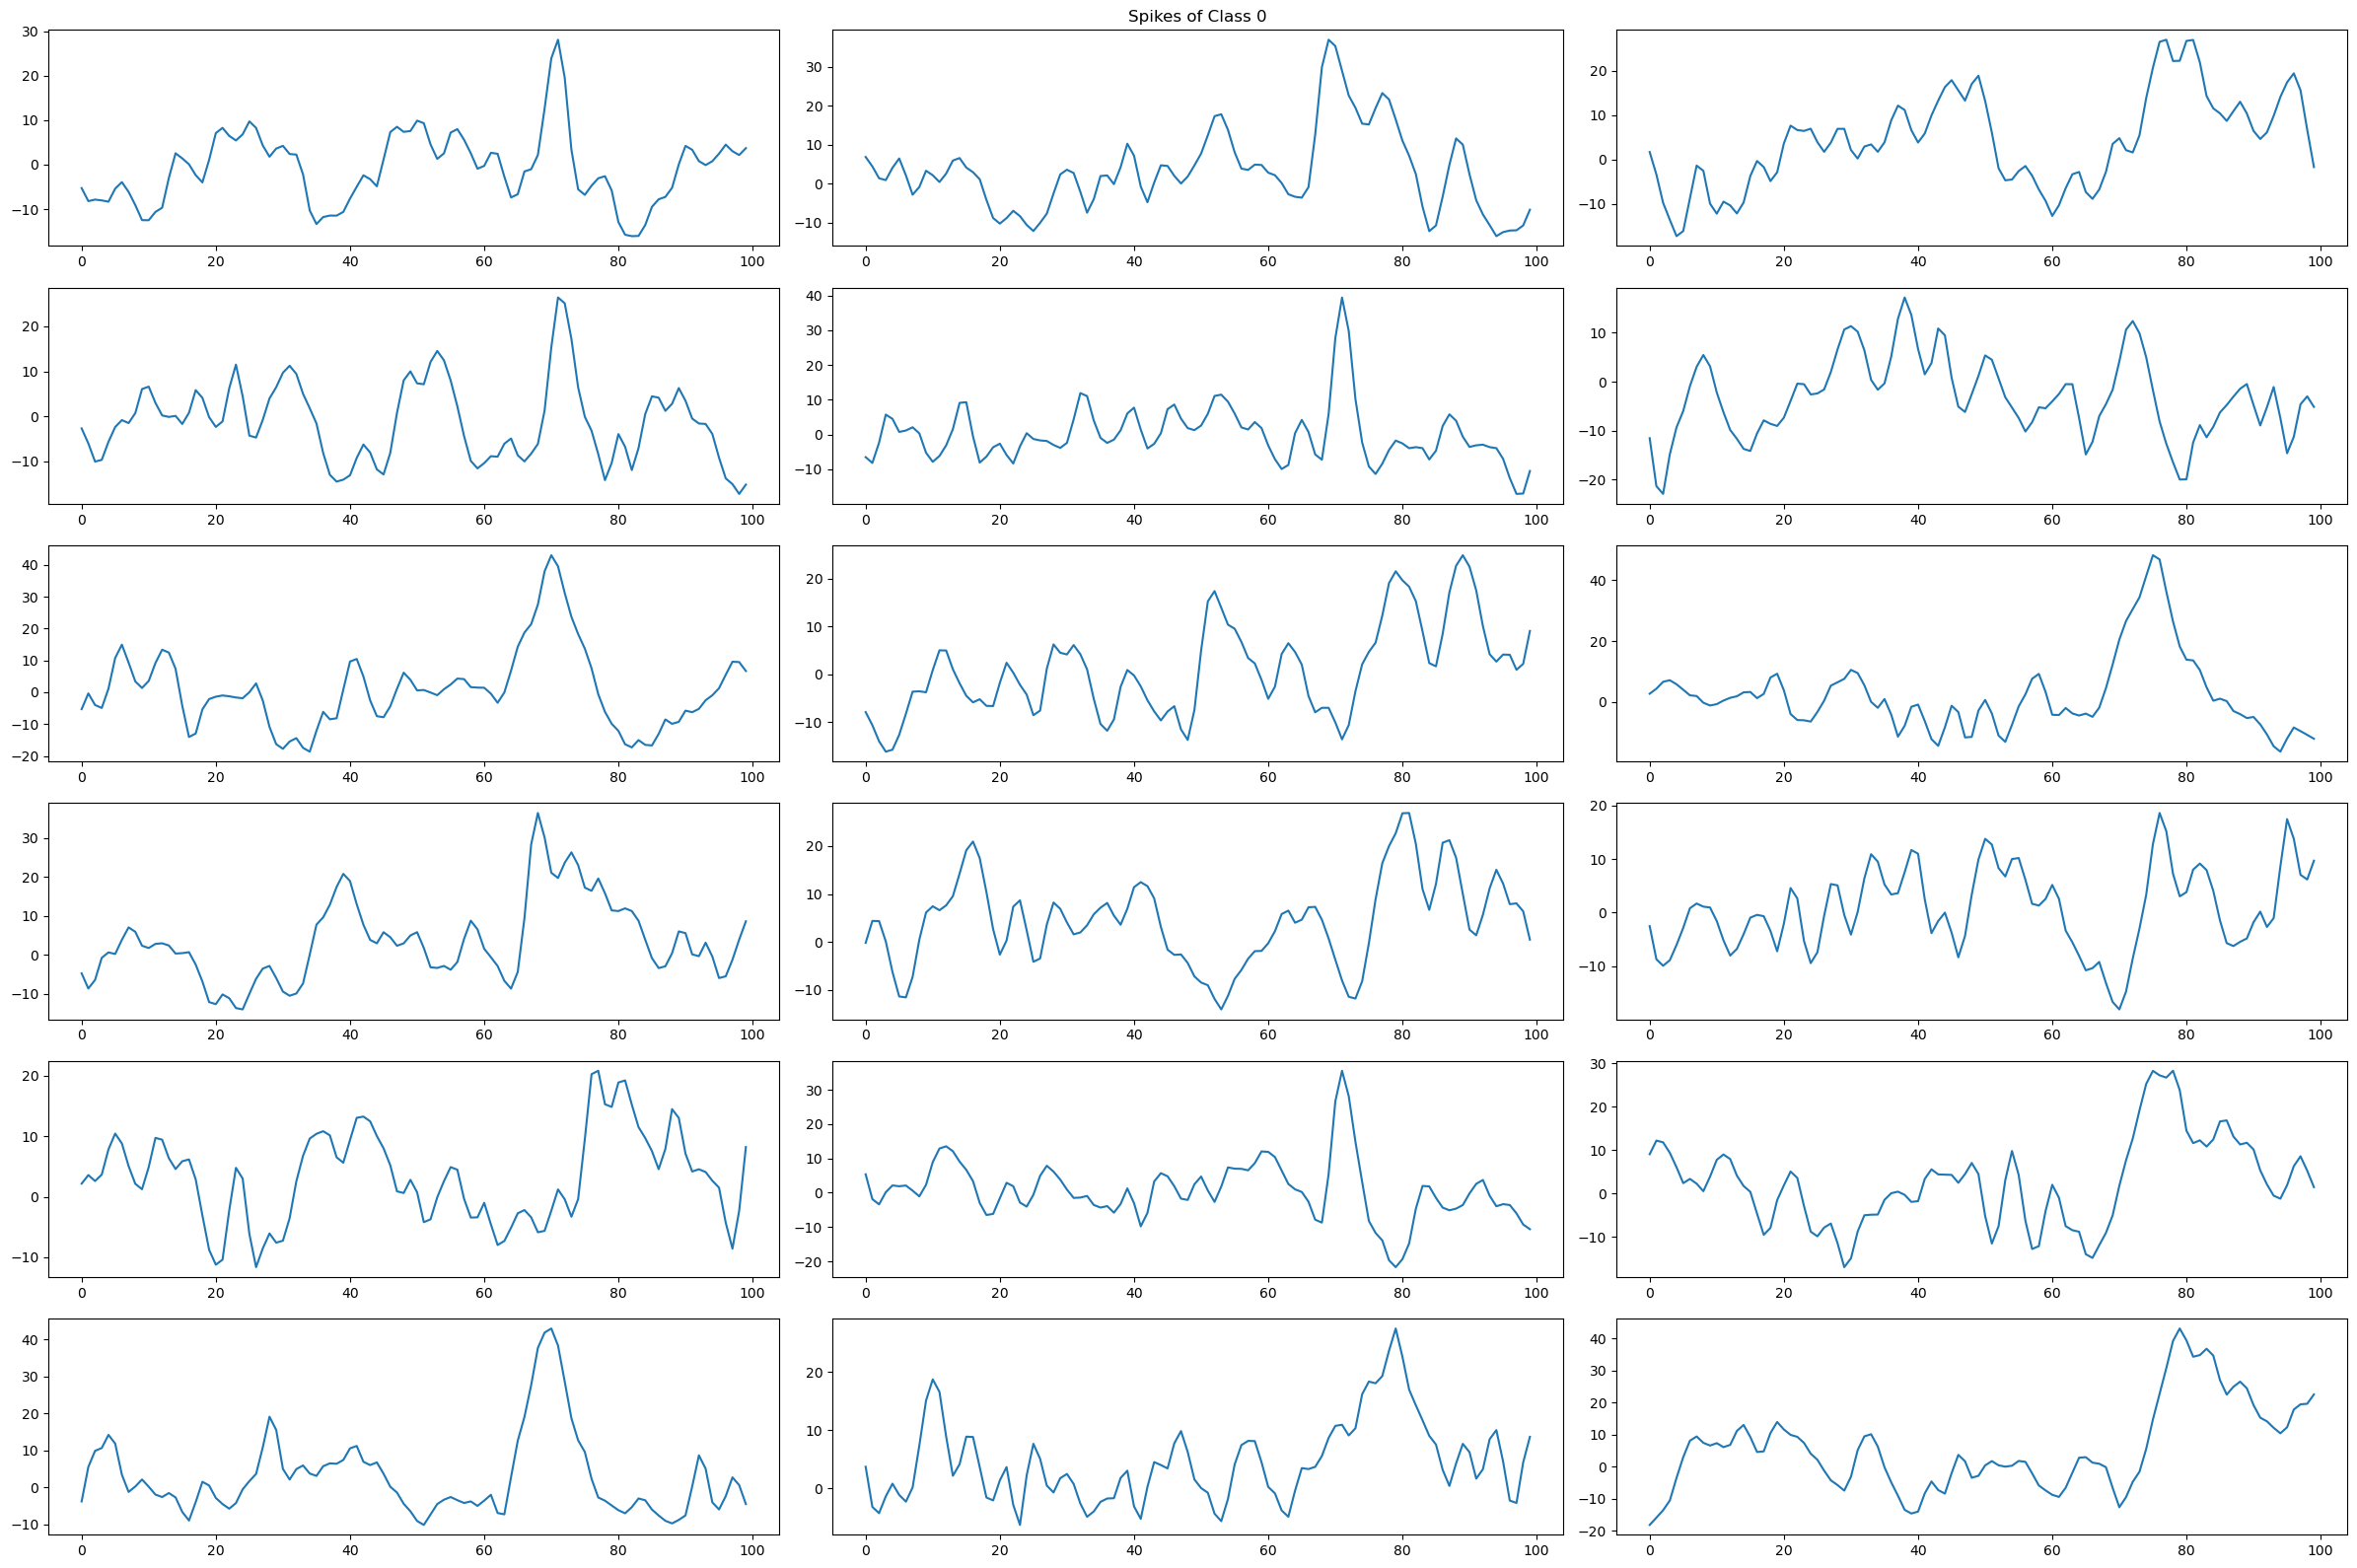

In [9]:
plot_clusters_by_class(0)

### Class 1

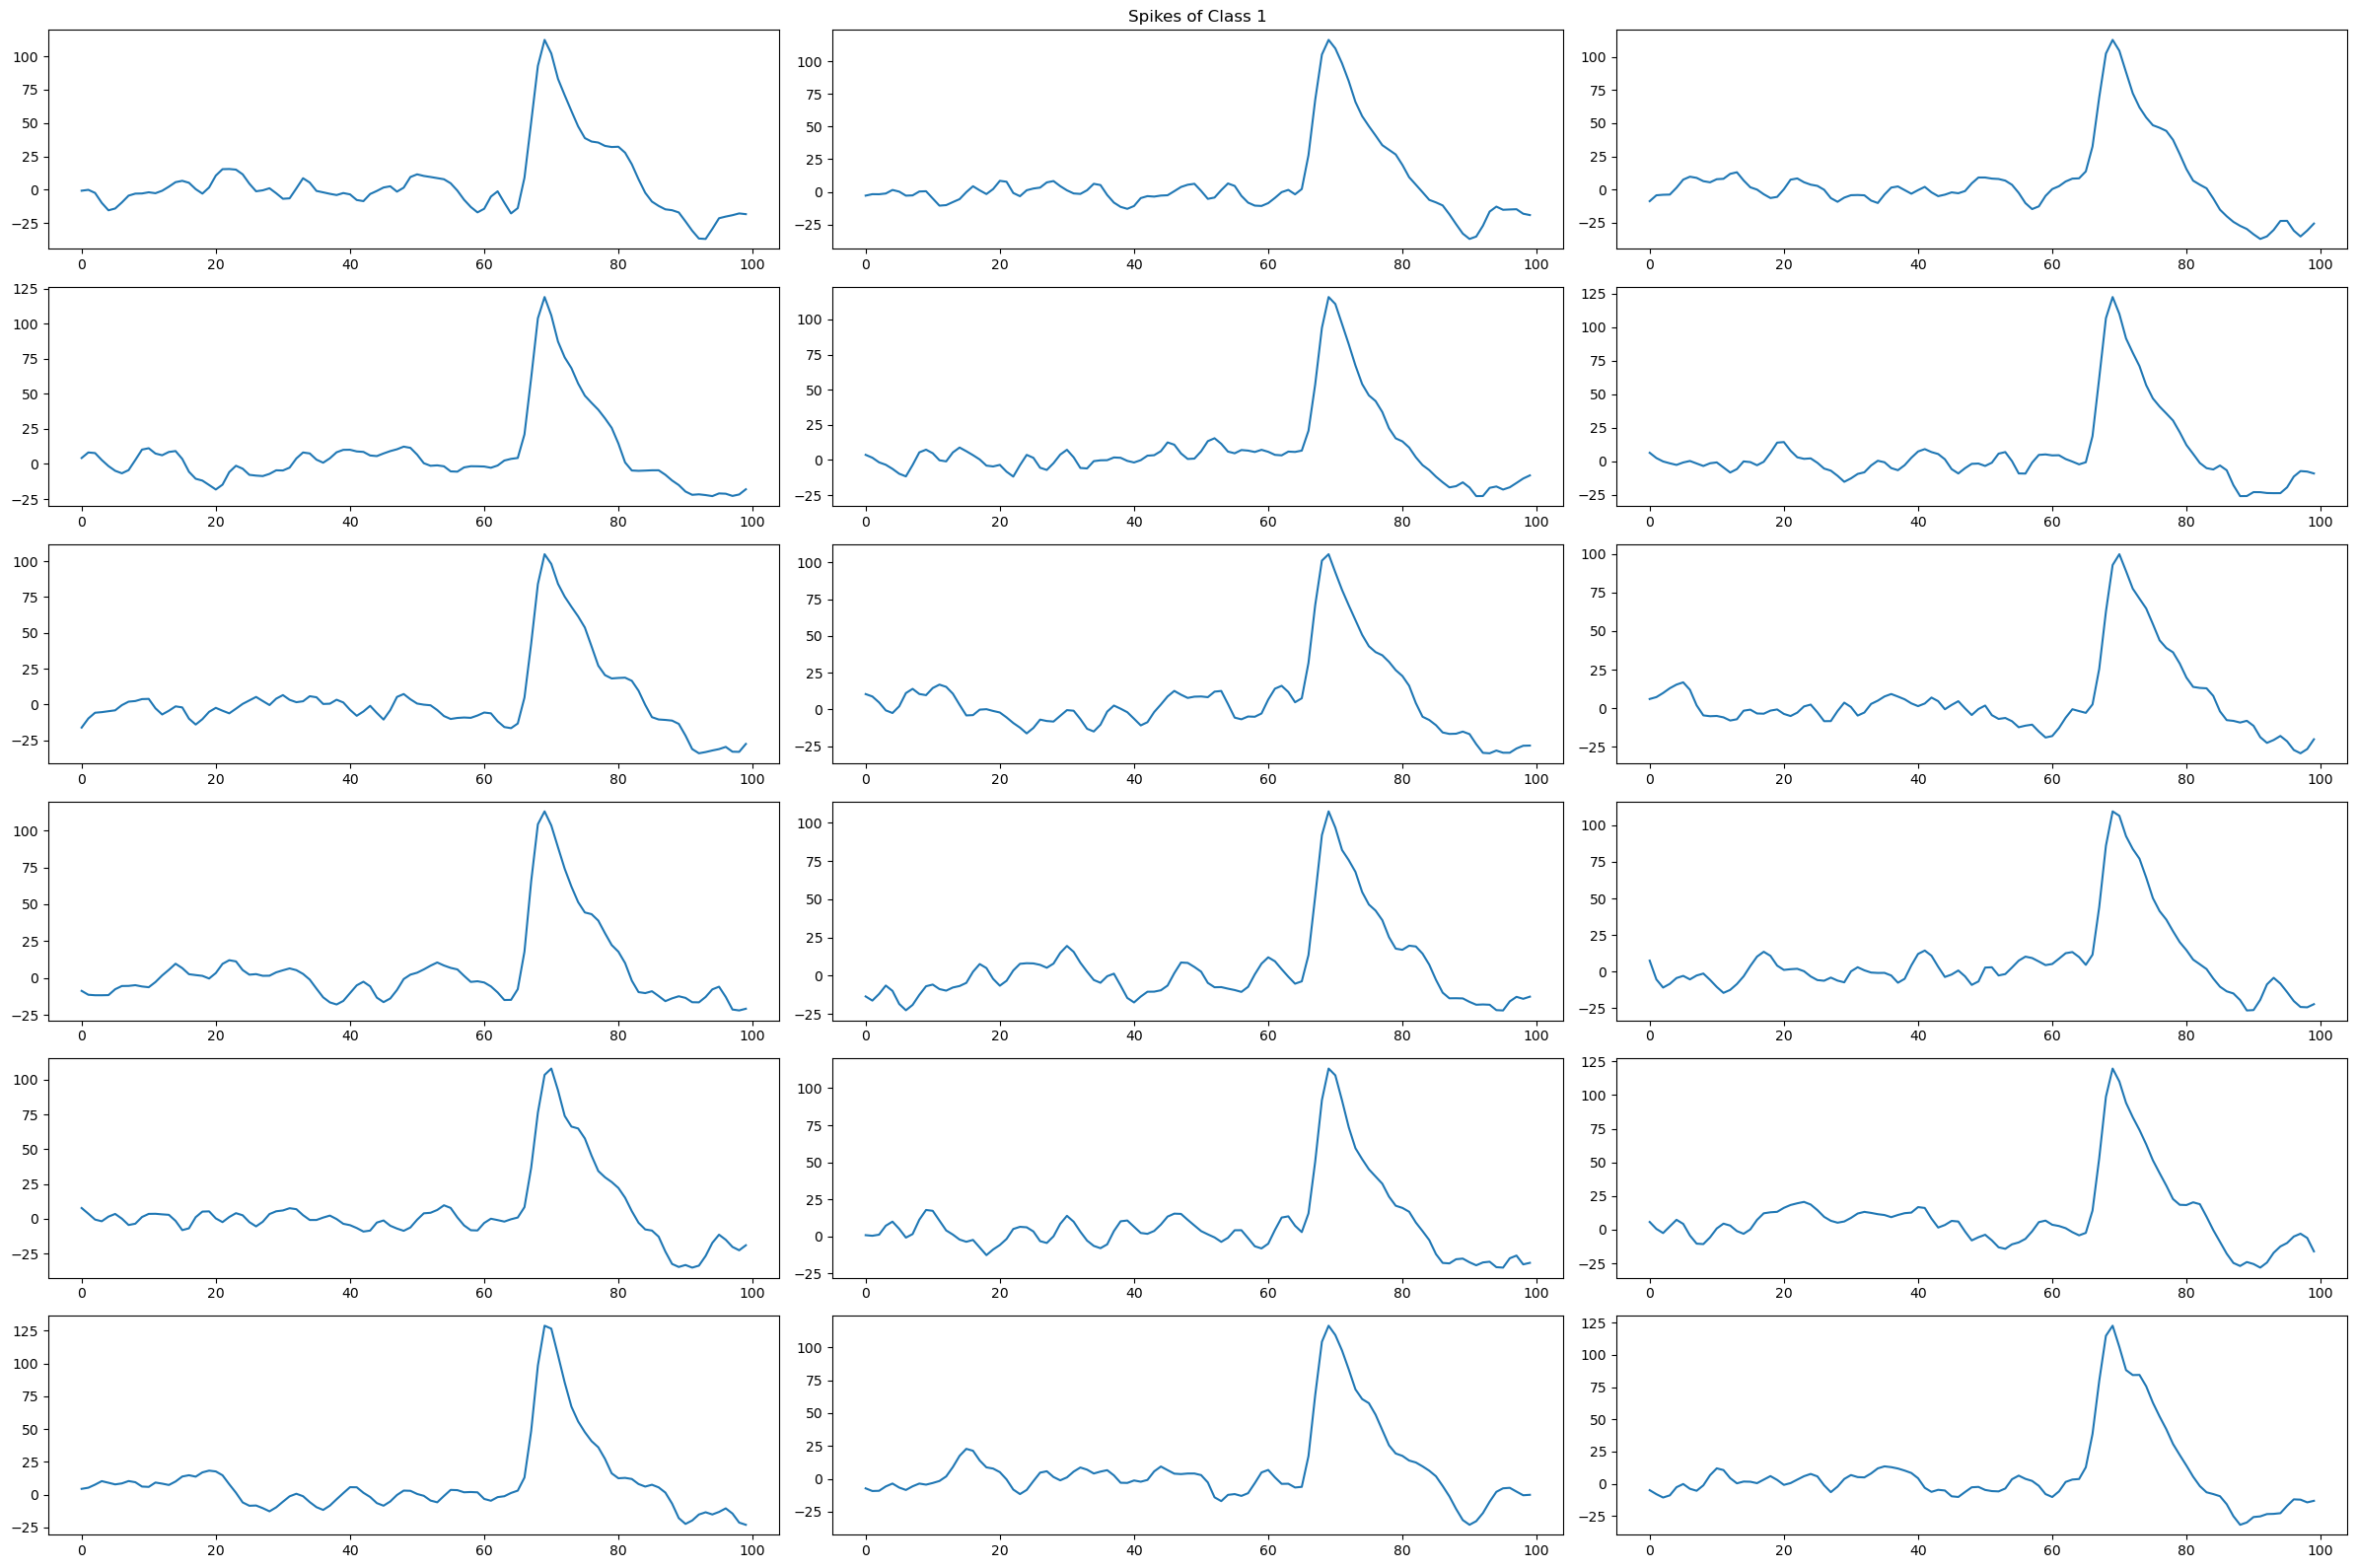

In [10]:
plot_clusters_by_class(1)

### Class 2

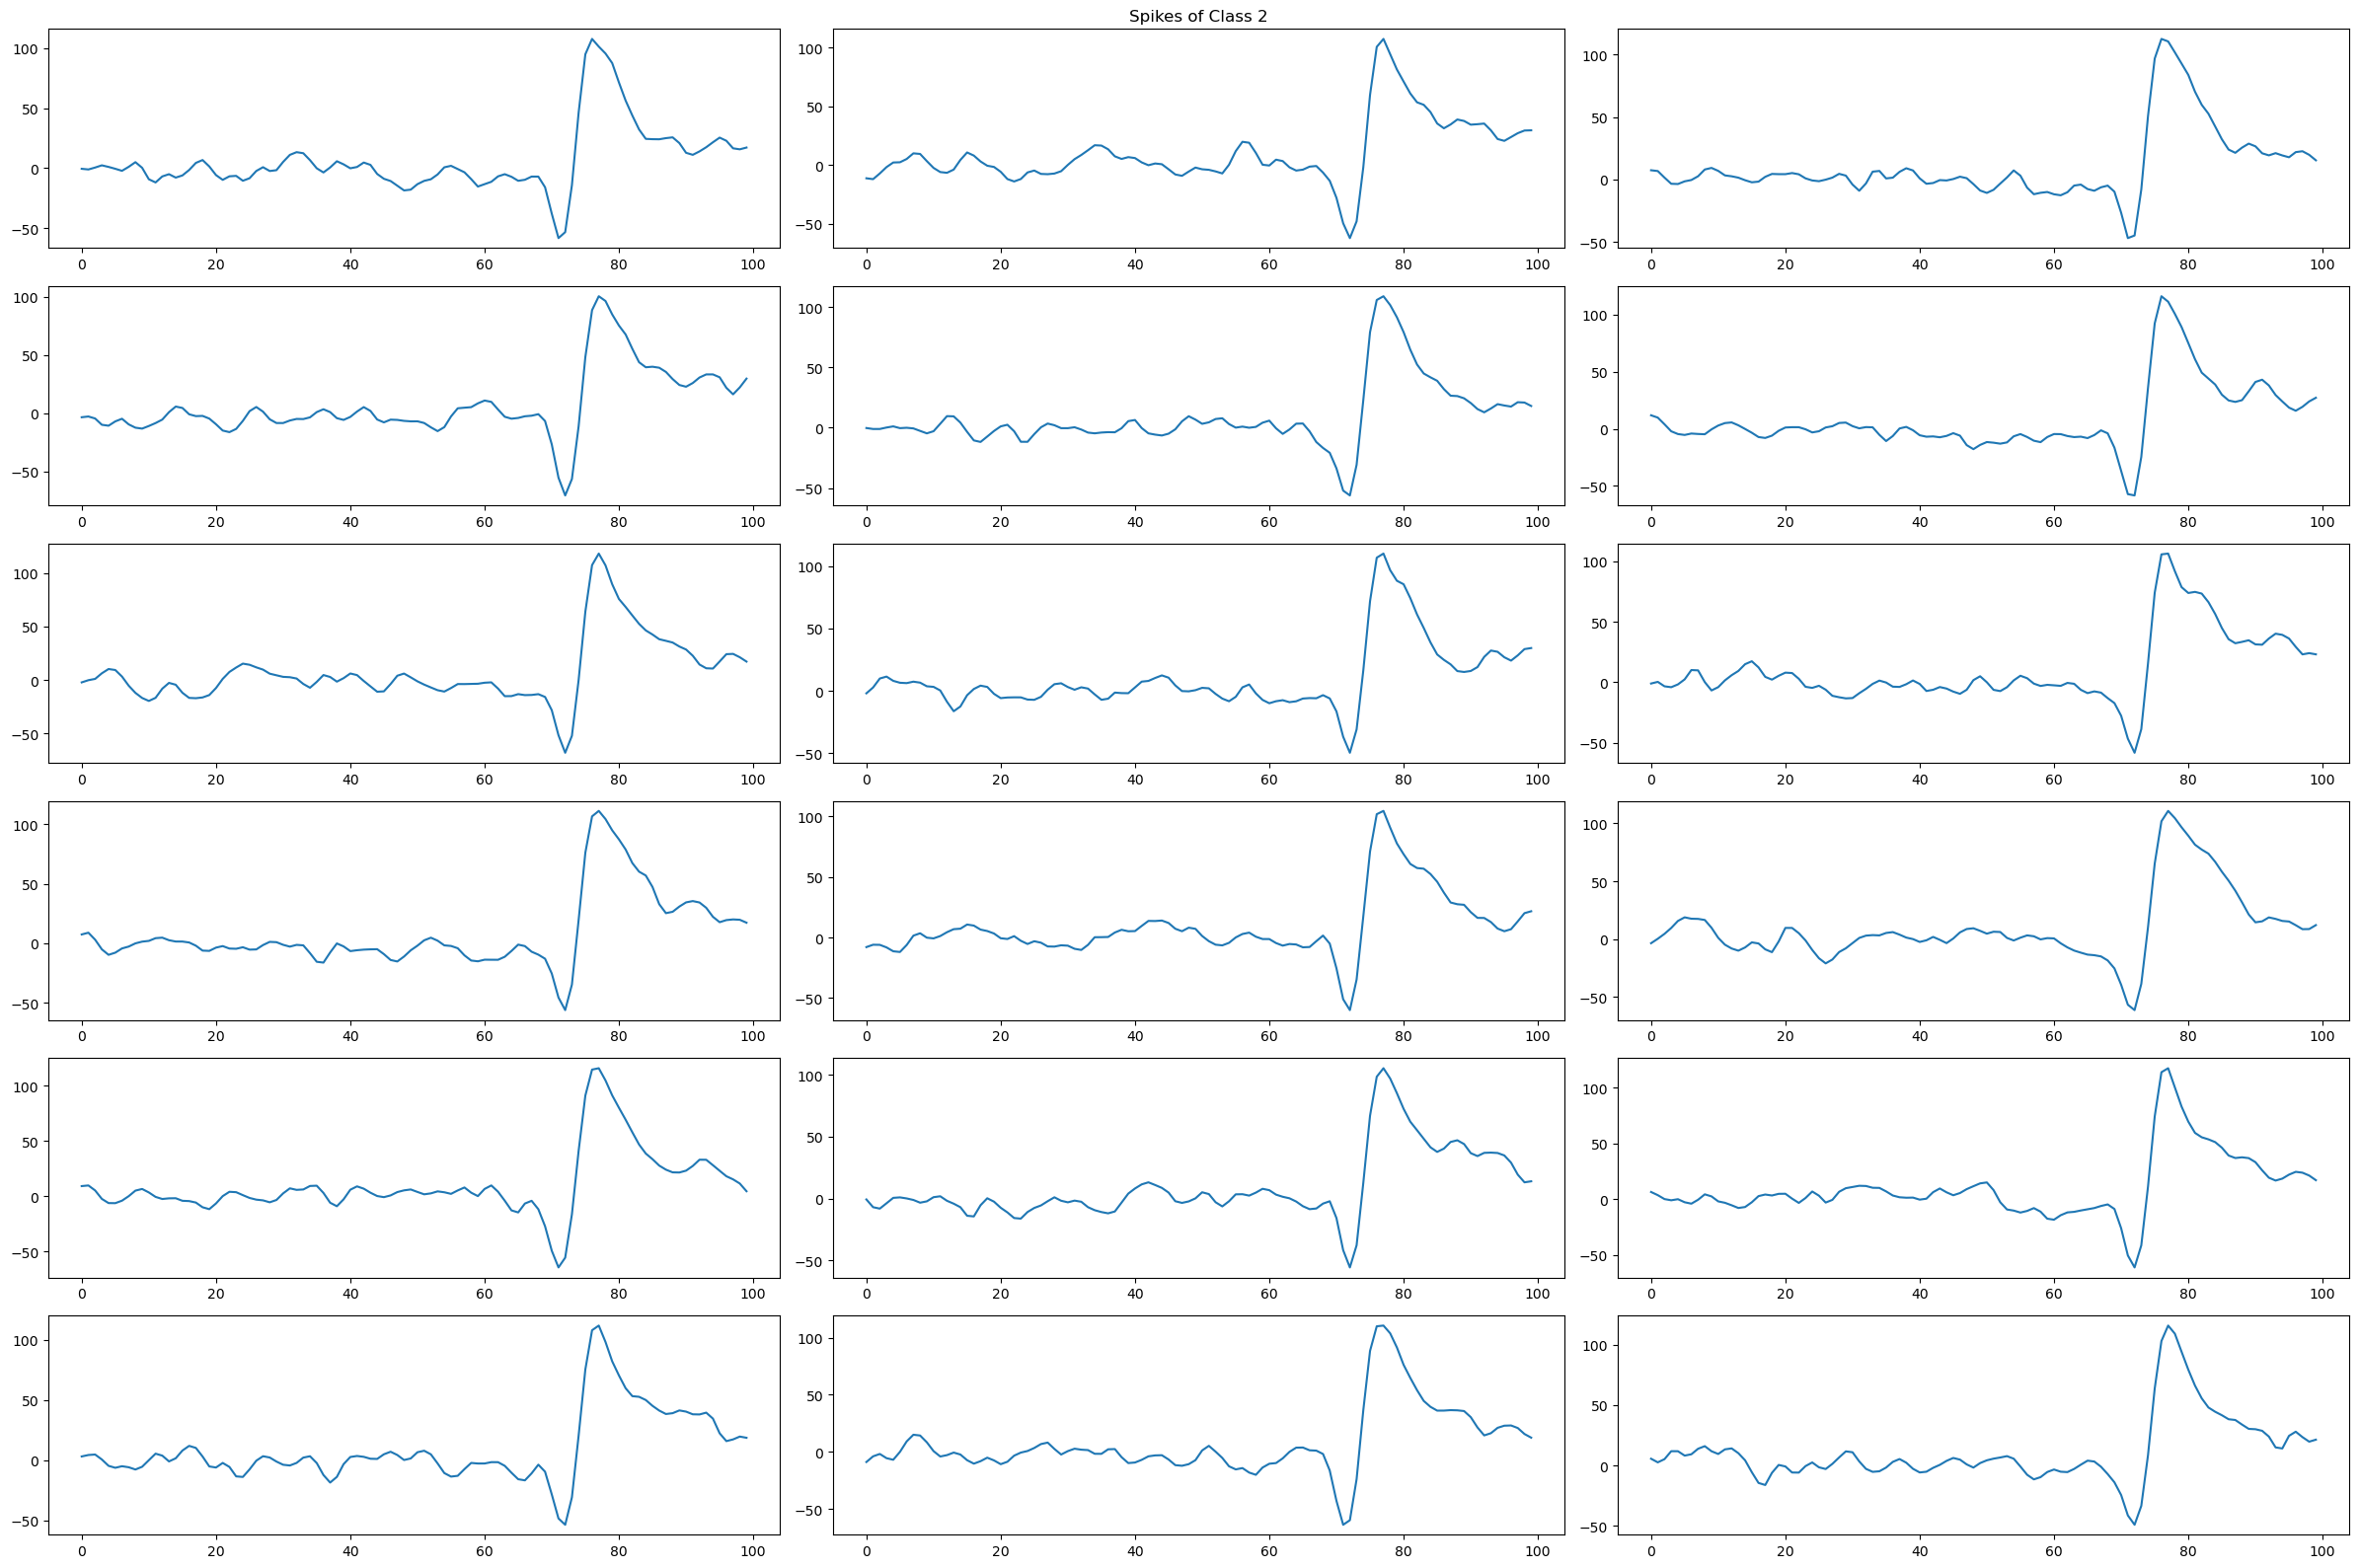

In [11]:
plot_clusters_by_class(2)

# Finding Spikes in the Data
First, we introduce metrics used to evaluate our approach. We will rely on precision and recall in the first step as they account for the number of false positve and false negative predictions that occur. 

If we consider the interval part of our learnable parameters then it might also make sense to introduce the metric "Intersect over Union" As this accounts for the total are of the intervals that match. 


In [12]:

def count_fn_fp(data, prediction):
    """"
    Count the number of false positives and false negatives
    Parameters: data (ground truth) and prediction as numpy arrays
    return: false negatives, false positives, true positive
    """
    
    matched_spikes = []
    true_positive_spikes = []
    
    for d in data:
        for p in prediction:
            if d < p < d + 30:
                # true positive found
                matched_spikes.append(d)
                true_positive_spikes.append(p)
                
    false_negative = np.setdiff1d(data, matched_spikes).shape[0]
    false_positive = np.setdiff1d(prediction, true_positive_spikes).shape[0]
    true_positive = np.array(true_positive_spikes).shape[0]
    
    return false_negative, false_positive, true_positive
            

def precision(data, prediction):
    fn, fp, tp = count_fn_fp(data, prediction)
    return tp/(tp+fp)

def recall(data, prediction):
    fn, fp, tp = count_fn_fp(data, prediction)
    return tp/(tp+fn)

    
def plot_confusion_matrix():
    # TODO: Does not make any sense as we do not have true negatives
    pass

def plot_precision_recall():
    # TODO: Only makes sense if we use this metric over a series of attempts to fit the parameters
    pass
    

## Without Z-Score 
In the first step I am setting a threshold based on the mean and the standard deviation of the data. 

In [13]:
# params
interval_param = 25
threshold_param = 2.7

# data
data = mat_file['data'][0]
spike_times = mat_file['spike_times'][0][0][0]


# mean and stdv
mean = np.mean(data, axis=0)
std_dev = np.std(data, axis=0)


threshold = mean + threshold_param * std_dev

For every data point I compare two consequitive data points with a threshold. If the first value was below the threshold and the second is above we detect this as a spike. 

In [ ]:
data = mat_file['data'][0]

# for i in range(data.shape[0]-1):
#     if data[i] < threshold and data[i+1] >= threshold:
#         detected_spikes.append(i)

detected_spikes = np.where((data > threshold).astype(int) == 1)[0]

print(detected_spikes)
# detected_spikes = np.array(detected_spikes).reshape(-1,)

# plt.plot(data[0:1000])
# 
# 
# plt.axvline(spike_times[np.where(spike_times<1000)], color='red', label="ground truth")
# 
# # plt.axvline(detected_spikes[np.where(detected_spikes<1000)], color='red', label="ground truth")
# for detected in detected_spikes:
#     if detected < 1000:
#         plt.axvline(detected, color='green', label="detected")
# 
# plt.legend()
# plt.show()


fn, fp, tp = count_fn_fp(data, detected_spikes)
print(f"There where {tp} spikes detected correctly out of {fn+tp}. [fn = {fn}, tp = {tp}, fp = {fp}]")
precision = precision(data, detected_spikes)
recall = recall(data, detected_spikes)
print(f"Precision: {precision}, Recall: {recall}")

[    566    1145    1146 ... 2879621 2879623 2879624]


Let's create some plots of what we detected. We will mark the detected spikes with a green line and the groundtruth with red as before. 

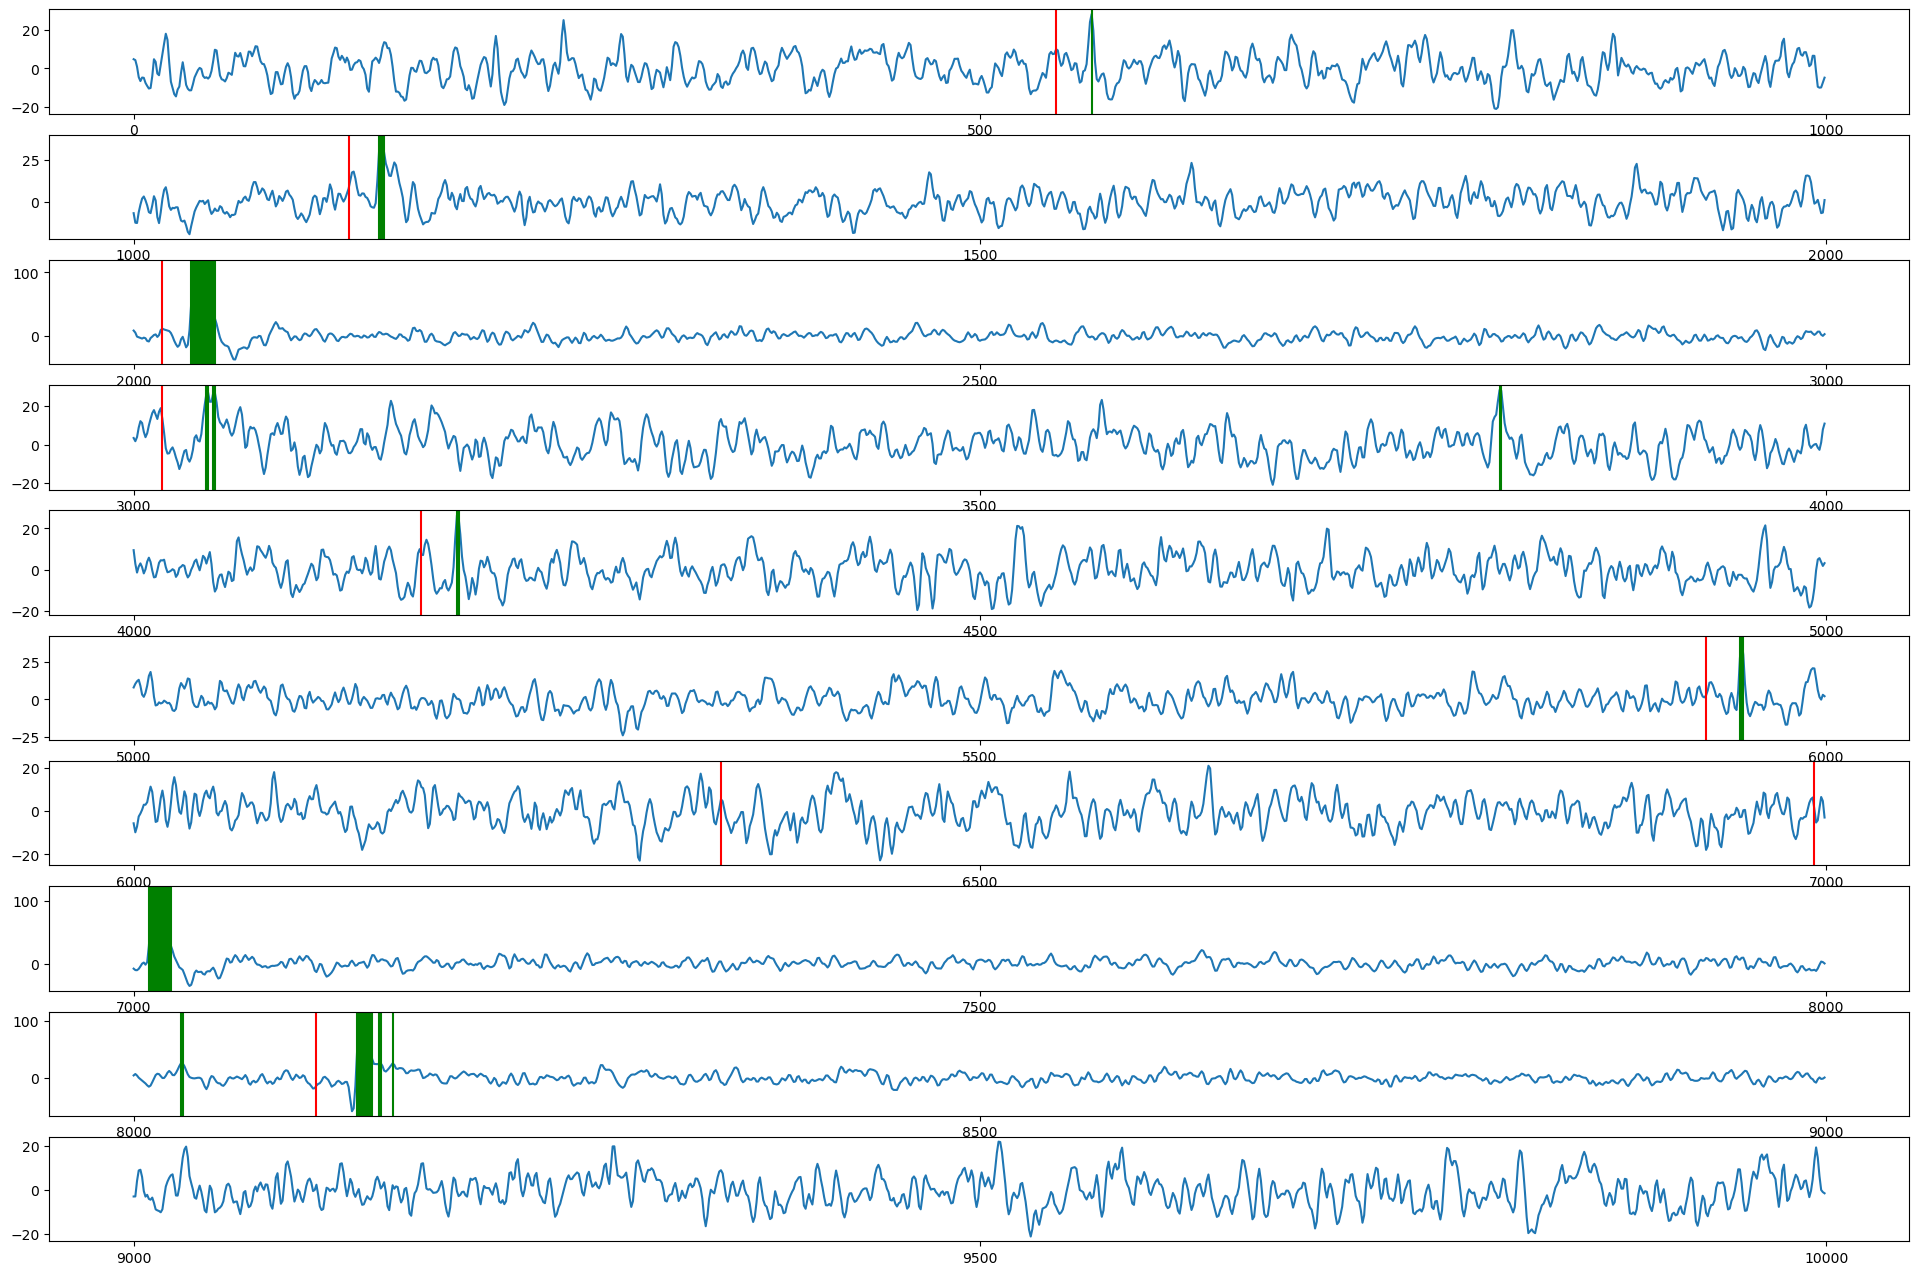

In [22]:
data = mat_file['data'][0][:10000]
spike_times = mat_file['spike_times'][0][0][0]

# TODO: Plot Spiketimes, fix x axis (include offset of continues time)

SUBPLOT_SIZE = 1000
N_SUBPLOTS = data.shape[0]//SUBPLOT_SIZE

fig, ax = plt.subplots(nrows=N_SUBPLOTS, ncols=1, figsize=(24,16))

for i in range(0, N_SUBPLOTS):
    start = i*SUBPLOT_SIZE
    end = (i+1)*SUBPLOT_SIZE
    
    ax[i].plot(data[start:end])
    ax[i].set_xticks([0, SUBPLOT_SIZE // 2, SUBPLOT_SIZE])
    ax[i].set_xticklabels([start, (start + end) // 2, end])
    
    # TODO: Clean up, first solution should work but doesnt. Need to get rid of the loops
    # ax[i].axvline(spike_times[np.where(i*SUBPLOT_SIZE<spike_times<i*SUBPLOT_SIZE+SUBPLOT_SIZE-1)], color='red', label="ground truth")    
    # ax[i].axvline(detected_spikes[np.where(i*SUBPLOT_SIZE<spike_times<i*SUBPLOT_SIZE+SUBPLOT_SIZE-1)], color='green', label="detected")
    
    
    for j, detected in enumerate(detected_spikes):
        if start < detected <= end:
            ax[i].axvline(detected-start, color='green', label="detected")
                
    for j, truth in enumerate(spike_times):
        if start < truth <= end:
            ax[i].axvline(truth-start, color='red', label="ground truth")
            
plt.show() 

We can again observe the offset between the true spike times and the local maxima. Our code detects the maxima. 

We can also see that there are some false positive detections in the first 10000 data points. 

Next steps are to use the Z-score for a more accurate comparison and finetune the threshhold. 

## With Z-Score

In [ ]:
data = mat_file['data'][0]

threshold = mean + 1 * std_dev

detected_spikes = []

for i in range(data.shape[0]-1):
    zscore_i = (data[i] - mean) / std_dev
    zscore_iplus1 = (data[i + 1] + mean) / std_dev
    if zscore_i < threshold and zscore_iplus1 >= threshold:
        detected_spikes.append(i)

In [ ]:
data = mat_file['data'][0][:10000]
spike_times = mat_file['spike_times'][0][0][0]

SUBPLOT_SIZE = 1000
N_SUBPLOTS = data.shape[0]//SUBPLOT_SIZE

fig, ax = plt.subplots(nrows=N_SUBPLOTS, ncols=1, figsize=(24,16))

for i in range(0, N_SUBPLOTS):
    start = i*SUBPLOT_SIZE
    end = (i+1)*SUBPLOT_SIZE
    
    ax[i].plot(data[start:end])
    ax[i].set_xticks([0, SUBPLOT_SIZE // 2, SUBPLOT_SIZE])
    ax[i].set_xticklabels([start, (start + end) // 2, end])
    
    # TODO: Clean up, first solution should work but doesnt. Need to get rid of the loops
    # ax[i].axvline(spike_times[np.where(i*SUBPLOT_SIZE<spike_times<i*SUBPLOT_SIZE+SUBPLOT_SIZE-1)], color='red', label="ground truth")    
    # ax[i].axvline(detected_spikes[np.where(i*SUBPLOT_SIZE<spike_times<i*SUBPLOT_SIZE+SUBPLOT_SIZE-1)], color='green', label="detected")
    
    
    for j, detected in enumerate(detected_spikes):
        if start < detected <= end:
            ax[i].axvline(detected-start, color='green', label="detected")
                
    for j, truth in enumerate(spike_times):
        if start < truth <= end:
            ax[i].axvline(truth-start, color='red', label="ground truth")
            
plt.show() 

## Without Z-Score and Average over a Several Points

In [ ]:
# TODO

# Trainable Parameters
## Threshold
If we set the threshold higher we will increase the number of false negative predictions. In other words, we will 

## Interval length

## Sliding Window (Average of group of points)